# Linear Regression

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

In [2]:
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')
#pip install scikit-learn --upgrade

RendererRegistry.enable('notebook')

## Introducing Scikit-Learn

There are several Python libraries which provide solid implementations of a range of machine learning algorithms.
One of the best known is [Scikit-Learn](http://scikit-learn.org), a package that provides efficient versions of a large number of common algorithms.
Scikit-Learn is characterized by a clean, uniform, and streamlined API, as well as by very useful and complete online documentation.
A benefit of this uniformity is that once you understand the basic use and syntax of Scikit-Learn for one type of model, switching to a new model or algorithm is very straightforward.

In [3]:
iris = pd.read_csv("data/iris.csv")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Here each row of the data refers to a single observed flower, and the number of rows is the total number of flowers in the dataset.
In general, we will refer to the rows of the matrix as *samples*, and the number of rows as ``n_samples``.

Likewise, each column of the data refers to a particular quantitative piece of information that describes each sample.
In general, we will refer to the columns of the matrix as *features*, and the number of columns as ``n_features``.

#### Features matrix

This table layout makes clear that the information can be thought of as a two-dimensional numerical array or matrix, which we will call the *features matrix*.
By convention, this features matrix is often stored in a variable named ``X``.
The features matrix is assumed to be two-dimensional, with shape ``[n_samples, n_features]``, and is most often contained in a NumPy array or a Pandas ``DataFrame``, though some Scikit-Learn models also accept SciPy sparse matrices.

#### Target array

In addition to the feature matrix ``X``, we also generally work with a *label* or *target* array, which by convention we will usually call ``y``.
The target array is usually one dimensional, with length ``n_samples``, and is generally contained in a NumPy array or Pandas ``Series``.
The target array may have continuous numerical values, or discrete classes/labels.
While some Scikit-Learn estimators do handle multiple target values in the form of a two-dimensional, ``[n_samples, n_targets]`` target array, we will primarily be working with the common case of a one-dimensional target array.

Often one point of confusion is how the target array differs from the other features columns. The distinguishing feature of the target array is that it is usually the quantity we want to *predict from the data*: in statistical terms, it is the dependent variable.
For example, in the preceding data we may wish to construct a model that can predict the species of flower based on the other measurements; in this case, the ``species`` column would be considered the target array.

In [5]:
chart = alt.Chart(iris).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='species:N'
).properties(
    width=100,
    height=100
).repeat(
    row=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
    column=['petal_width', 'petal_length', 'sepal_width', 'sepal_length']
)

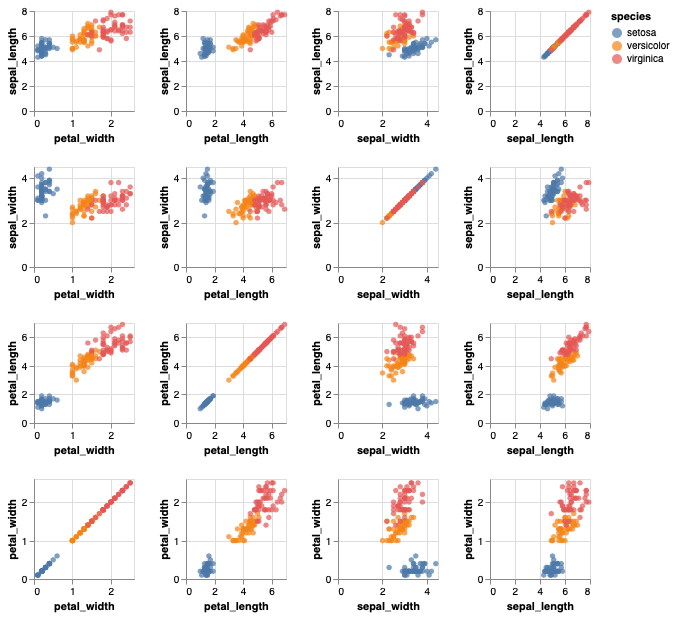

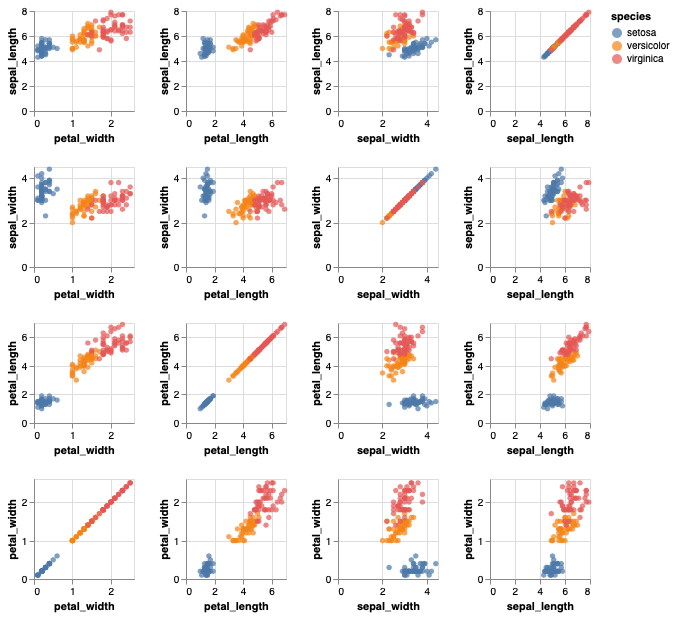

In [6]:
chart

In [7]:
X_iris = iris.drop('species', axis=1)
X_iris.shape

(150, 4)

In [9]:
y_iris = iris['species']
y_iris.shape

(150,)

To summarize, the expected layout of features and target values is visualized in the following diagram:
![](figures/05.02-samples-features.png)

### Basics of the API

Most commonly, the steps in using the Scikit-Learn estimator API are as follows
(we will step through a handful of detailed examples in the sections that follow).

1. Choose a class of model by importing the appropriate estimator class from Scikit-Learn.
2. Choose model hyperparameters by instantiating this class with desired values.
3. Arrange data into a features matrix and target vector following the discussion above.
4. Fit the model to your data by calling the ``fit()`` method of the model instance.
5. Apply the Model to new data:
   - For supervised learning, often we predict labels for unknown data using the ``predict()`` method.
   - For unsupervised learning, we often transform or infer properties of the data using the ``transform()`` or ``predict()`` method.

We will now step through several simple examples of applying supervised and unsupervised learning methods.

### Supervised learning example: Simple linear regression

As an example of this process, let's consider a simple linear regression—that is, the common case of fitting a line to $(x, y)$ data.
We will use the following simple data for our regression example:

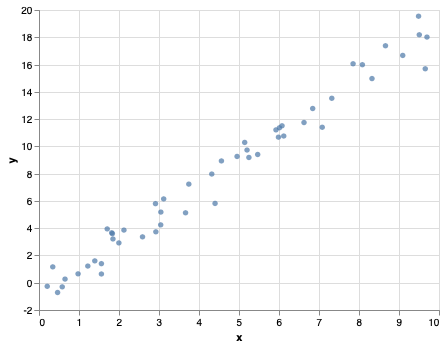

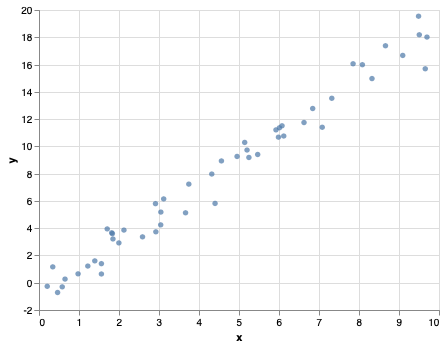

In [17]:
import numpy as np

rng = np.random.RandomState(42)
x = 10 * rng.rand(50)
y = 2 * x - 1 + rng.randn(50)

alt.Chart(pd.DataFrame({'x':x, 'y':y})).mark_circle().encode(x='x', y='y', tooltip = ['x', 'y'])


#### 1. Choose a class of model

In Scikit-Learn, every class of model is represented by a Python class.
So, for example, if we would like to compute a simple linear regression model, we can import the linear regression class:

In [18]:
from sklearn.linear_model import LinearRegression

#### 2. Choose model hyperparameters

An important point is that *a class of model is not the same as an instance of a model*.

Once we have decided on our model class, there are still some options open to us.
Depending on the model class we are working with, we might need to answer one or more questions like the following:

- Would we like to fit for the offset (i.e., *y*-intercept)?
- Would we like the model to be normalized?
- Would we like to preprocess our features to add model flexibility?
- What degree of regularization would we like to use in our model?
- How many model components would we like to use?

These are examples of the important choices that must be made *once the model class is selected*.
These choices are often represented as *hyperparameters*, or parameters that must be set before the model is fit to data.
In Scikit-Learn, hyperparameters are chosen by passing values at model instantiation.
We will explore how you can quantitatively motivate the choice of hyperparameters in [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb).

For our linear regression example, we can instantiate the ``LinearRegression`` class and specify that we would like to fit the intercept using the ``fit_intercept`` hyperparameter:

In [19]:
model = LinearRegression(fit_intercept=True)
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### 3. Arrange data into a features matrix and target vector

Previously we detailed the Scikit-Learn data representation, which requires a two-dimensional features matrix and a one-dimensional target array.
Here our target variable ``y`` is already in the correct form (a length-``n_samples`` array), but we need to massage the data ``x`` to make it a matrix of size ``[n_samples, n_features]``.
In this case, this amounts to a simple reshaping of the one-dimensional array:

In [20]:
X = x[:, np.newaxis]
X.shape

(50, 1)

#### 4. Fit the model to your data

Now it is time to apply our model to data.
This can be done with the ``fit()`` method of the model:

In [21]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

This ``fit()`` command causes a number of model-dependent internal computations to take place, and the results of these computations are stored in model-specific attributes that the user can explore.
In Scikit-Learn, by convention all model parameters that were learned during the ``fit()`` process have trailing underscores; for example in this linear model, we have the following:

In [22]:
model.coef_

array([1.9776566])

In [23]:
model.intercept_

-0.9033107255311164

#### 5. Predict labels for unknown data

Once the model is trained, the main task of supervised machine learning is to evaluate it based on what it says about new data that was not part of the training set.
In Scikit-Learn, this can be done using the ``predict()`` method.
For the sake of this example, our "new data" will be a grid of *x* values, and we will ask what *y* values the model predicts:

In [24]:
xfit = np.linspace(-1, 11)

As before, we need to coerce these *x* values into a ``[n_samples, n_features]`` features matrix, after which we can feed it to the model:

In [25]:
Xfit = xfit[:, np.newaxis]
yfit = model.predict(Xfit)

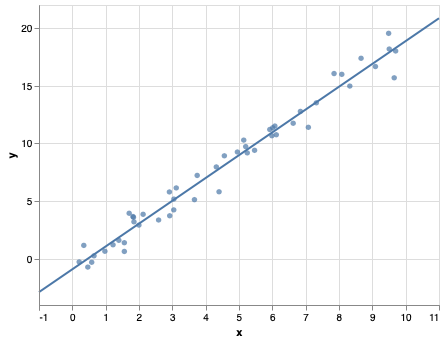

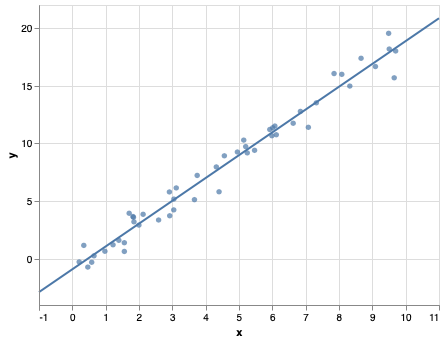

In [27]:
alt.Chart(pd.DataFrame({'x':x, 'y':y})).mark_circle().encode(x='x', y='y') + alt.Chart(pd.DataFrame({'x':xfit, 'y':yfit})).mark_line().encode(x='x', y='y')



# Predict car mileage
Predict `Miles_per_Gallon` using the other features in the data set. How good is this prediction?

In [44]:
data=pd.read_json('data/cars.json').dropna()
data.head()

,Acceleration,Cylinders,Displacement,Horsepower,Miles_per_Gallon,Name,Origin,Weight_in_lbs,Year
0,12.0,8,307.0,130.0,18.0,chevrolet chevelle malibu,USA,3504,1970-01-01
1,11.5,8,350.0,165.0,15.0,buick skylark 320,USA,3693,1970-01-01
2,11.0,8,318.0,150.0,18.0,plymouth satellite,USA,3436,1970-01-01
3,12.0,8,304.0,150.0,16.0,amc rebel sst,USA,3433,1970-01-01
4,10.5,8,302.0,140.0,17.0,ford torino,USA,3449,1970-01-01


Let us start with one feature `Weight_in_lbs`


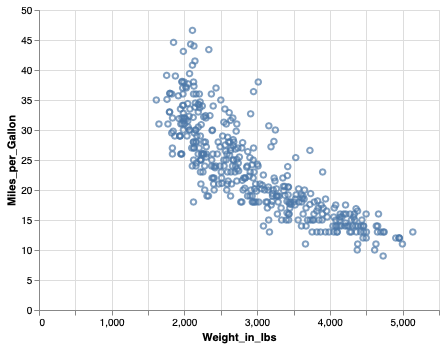

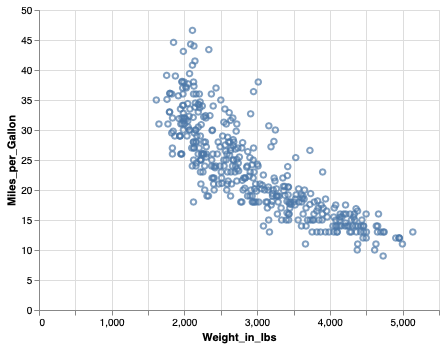

In [45]:
alt.Chart(data).mark_point().encode(x='Weight_in_lbs', y='Miles_per_Gallon')

In [46]:
X = data[['Weight_in_lbs']]
y = data['Miles_per_Gallon']

In [47]:
model = LinearRegression(fit_intercept=True)
model.fit(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [48]:
model.coef_

array([-0.00764734])

In [49]:
model.intercept_

46.21652454901758

In [52]:
yfit = model.predict(X)
data['predicted_mpg'] = yfit

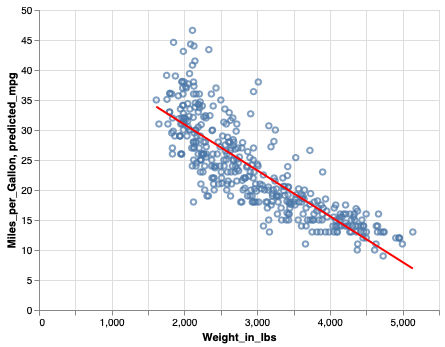

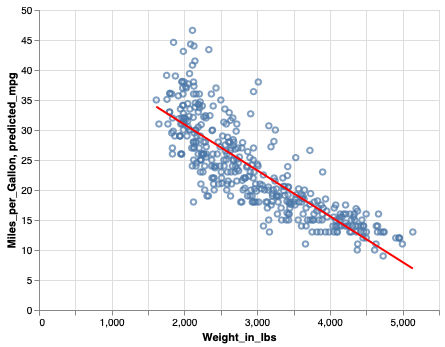

In [70]:
chart1 = alt.Chart(data).mark_point().encode(x='Weight_in_lbs', y='Miles_per_Gallon')
chart2 = alt.Chart(data).mark_line(color='red').encode(x='Weight_in_lbs', y='predicted_mpg')
chart1 + chart2

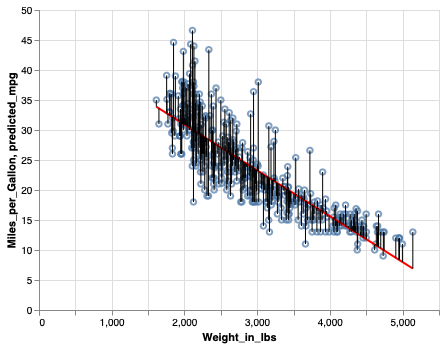

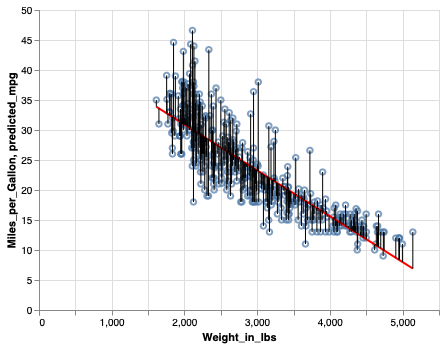

In [71]:
chart3 = alt.Chart(data).mark_line().encode(x='Weight_in_lbs', y='Miles_per_Gallon', y2='predicted_mpg')
chart1+chart2+chart3


In [78]:
resid = y-yfit
resid.head()

0   -1.420236
1   -2.974889
2   -1.940256
3   -3.963198
4   -2.840840
Name: Miles_per_Gallon, dtype: float64

In [81]:
mss = (resid**2).mean()
mss

18.6766165974193

In [85]:
from sklearn.metrics import r2_score
r2_score(y, yfit)

0.6926304331206254

Can we do better?

In [99]:
data['Year']=data['Year'].str[:4].apply(int)

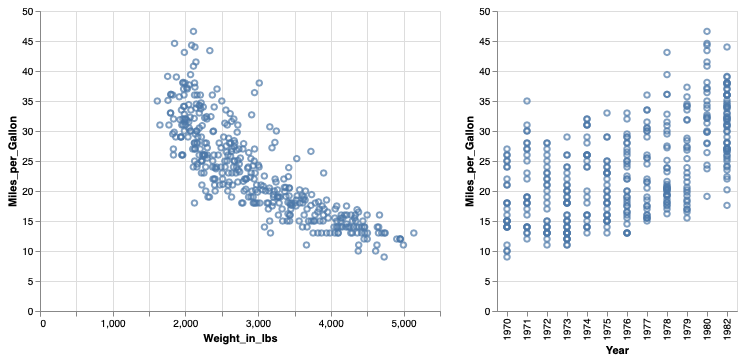

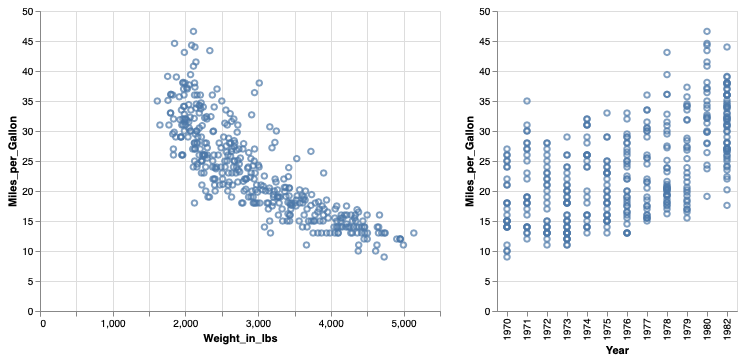

In [101]:
c1 = alt.Chart(data).mark_point().encode(x='Weight_in_lbs', y='Miles_per_Gallon')
c2 = alt.Chart(data).mark_point().encode(x='Year:O', y='Miles_per_Gallon')
c1 | c2

In [102]:
X = data[['Weight_in_lbs', 'Year']]
y = data['Miles_per_Gallon']

In [103]:
model = LinearRegression(fit_intercept=True)
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [115]:
model.intercept_

-1408.9628546031286

In [116]:
model.coef_

array([-0.00662953,  0.73487412])

In [105]:
yfit = model.predict(X)
data['predicted_mpg2']=yfit


0.8076224299455275

In [114]:
resid = y-yfit
(resid**2).mean()

11.689387971388179

In [ ]:
r2_score(y, yfit)

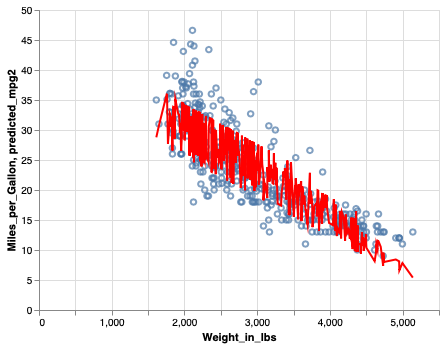

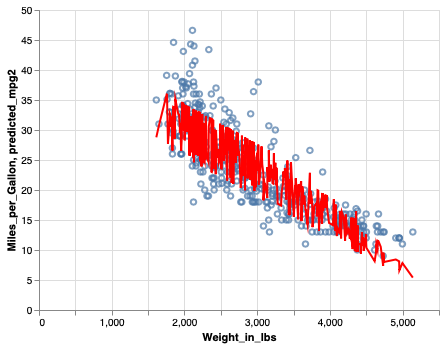

In [108]:
chart1 = alt.Chart(data).mark_point().encode(x='Weight_in_lbs', y='Miles_per_Gallon')
chart2 = alt.Chart(data).mark_line(color='red').encode(x='Weight_in_lbs', y='predicted_mpg2')
chart1 + chart2

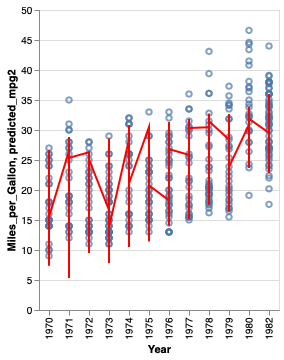

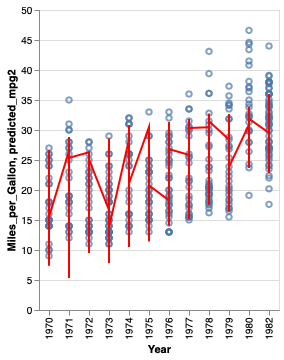

In [113]:
chart1 = alt.Chart(data).mark_point().encode(x='Year:O', y='Miles_per_Gallon')
chart2 = alt.Chart(data).mark_line(color='red').encode(x='Year:O', y='predicted_mpg2')
chart1 + chart2

Can we incorporate `Origin` in our model?

In [122]:
data.dtypes

Acceleration        float64
Cylinders             int64
Displacement        float64
Horsepower          float64
Miles_per_Gallon    float64
Name                 object
Origin               object
Weight_in_lbs         int64
Year                  int64
y                   float64
predicted_mpg       float64
predicted_mpg2      float64
dtype: object

In [124]:
data2 = pd.get_dummies(data.drop('Name', axis=1))
data2.head()

,Acceleration,Cylinders,Displacement,Horsepower,Miles_per_Gallon,Weight_in_lbs,Year,y,predicted_mpg,predicted_mpg2,Origin_Europe,Origin_Japan,Origin_USA
0,12.0,8,307.0,130.0,18.0,3504,1970,19.420236,19.420236,15.509290,0,0,1
1,11.5,8,350.0,165.0,15.0,3693,1970,17.974889,17.974889,14.256309,0,0,1
2,11.0,8,318.0,150.0,18.0,3436,1970,19.940256,19.940256,15.960099,0,0,1
3,12.0,8,304.0,150.0,16.0,3433,1970,19.963198,19.963198,15.979987,0,0,1
4,10.5,8,302.0,140.0,17.0,3449,1970,19.840840,19.840840,15.873915,0,0,1


In [138]:
X = data2[['Weight_in_lbs', 'Year', 'Origin_Europe', 'Origin_Japan', 'Origin_USA']]
y = data2['Miles_per_Gallon']

In [141]:
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
yfit = model.predict(X)
r2_score(y, yfit)

0.8182845130920839

In [142]:
model.coef_

array([-0.00589203,  0.74681943,  0.59428767,  0.79163862, -1.38592629])

In [143]:
model.intercept_

-1434.159775079693